In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
batch_size=256
learning_rate=0.001
epochs=30

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_train, fmnist_val=torch.utils.data.random_split(fmnist_train, [50000, 10000])

In [ ]:
dataloader=dict()
dataloader["train"]=DataLoader(fmnist_train, batch_size, shuffle=True)
dataloader["val"]=DataLoader(fmnist_val, batch_size, shuffle=False)
dataloader["test"]=DataLoader(fmnist_test, batch_size, shuffle=False)

In [ ]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# A : VGG-11
# B : VGG-13
# D : VGG-16
# E : VGG-19

def make_layer(config):
  layers=[]
  in_planes=1
  for value in config:
    if value=="M":
      layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    else:
      layers.append(nn.Conv2d(in_planes,value,kernel_size=3,padding=1))
      layers.append(nn.ReLU())
      in_planes=value
  return nn.Sequential(*layers)

In [ ]:
class VGG(nn.Module):
  def __init__(self, config):
    super(VGG, self).__init__()
    self.features=make_layer(config)

    self.classifier=nn.Sequential(
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,10)
    )
  def forward(self,x):
    out=self.features(x)
    out=out.reshape(-1,512)
    out=self.classifier(out)
    return out

In [ ]:
model=VGG(cfg['D']).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
best_model=copy.deepcopy(model.state_dict())
best_eval_loss=float('inf')
train_history=[]
eval_history=[]
for epoch in range(epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    running_loss = 0.0
    for x,y in dataloader[phase]:
      x=x.to(device)
      px=F.pad(x,(2,2,2,2),"constant",0)
      y=y.to(device)
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=='train'):
        output=model(px)
        loss=criterion(output,y)
        if phase=='train':
          loss.backward()
          optimizer.step()
      running_loss+=loss.item()
      epoch_loss = running_loss / len(dataloader[phase].dataset)

    if phase=='train':
      print(f'Epoch {epoch}/{epochs-1}')
      print(f'train loss: {epoch_loss}')
      train_history.append(epoch_loss)
    else:
      print(f'eval loss: {epoch_loss}')
      eval_history.append(epoch_loss)
      if epoch_loss<best_eval_loss:
        best_eval_loss=epoch_loss
        best_model=copy.deepcopy(model.state_dict())

print(f'Best Validation Loss: {best_eval_loss}')

Epoch 0/29
train loss: 0.009140058388710022
eval loss: 0.009164124989509583
Epoch 1/29
train loss: 0.005968359094858169
eval loss: 0.003566601866483688
Epoch 2/29
train loss: 0.0027632666724920272
eval loss: 0.0021339036136865616
Epoch 3/29
train loss: 0.0019885460543632508
eval loss: 0.0017542024314403533
Epoch 4/29
train loss: 0.0016771224403381347
eval loss: 0.0014945880502462386
Epoch 5/29
train loss: 0.0014368877524137498
eval loss: 0.0014457395300269127
Epoch 6/29
train loss: 0.0013292772570252418
eval loss: 0.0012872981131076813
Epoch 7/29
train loss: 0.0012281480610370635
eval loss: 0.001243458753824234
Epoch 8/29
train loss: 0.001136936422586441
eval loss: 0.001148020166158676
Epoch 9/29
train loss: 0.0010964079722762107
eval loss: 0.00114684287160635
Epoch 10/29
train loss: 0.0010223444437980653
eval loss: 0.0011615310907363893
Epoch 11/29
train loss: 0.0009764384889602661
eval loss: 0.0010851205870509148
Epoch 12/29
train loss: 0.0009228173100948334
eval loss: 0.001046902535

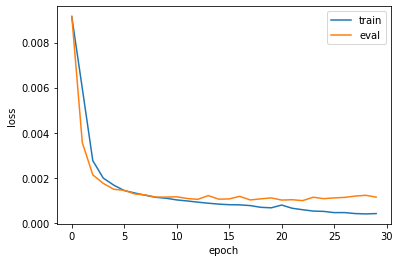

In [ ]:
plt.plot(train_history, label="train")
plt.plot(eval_history, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(best_model)
total=0
correct=0
with torch.no_grad():
  for x,y in dataloader['test']:
    x=F.pad(x,(2,2,2,2),"constant",0).to(device)
    y=y.to(device)
    output=model(x)
    _,pred=torch.max(output.data,1)
    total+=y.size(0)
    correct+=(pred==y).sum().item()

print(f'Accuracy: {100*correct/total}')

Accuracy: 91.28
